## How to use the UMAP algorithm on APOGEE globular cluster data. 
##### Steffani Grondin (September 23, 2022)

In [ ]:
#%pip uninstall umap
%pip install umap-learn

#### STEP 0: Import the necessary packages/algorithms.

In [2]:
# General analysis/plotting packages:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
from collections import Counter

# Specific t-SNE/visualization packages:
from shapely.geometry import Point, Polygon

# Import UMAP
import umap.umap_ as umap

# Try using SKLEARN's StandardScaler to standardize the data
from sklearn.preprocessing import StandardScaler



#### STEP 1: Load in the M3 datafile. 

This example uses APOGEE DR17 data (https://www.sdss.org/dr17/) with astroNN chemical abundances (https://astronn.readthedocs.io/en/latest/) and includes all stars that are within a 10x10 degree field of view around M3's centre.

In [3]:
M3 = pd.read_csv('data/M3data_10x10.csv', delimiter=',')

# Spatial:
ra = M3["ra"]   #APOGEE
dec = M3["dec"]   #APOGEE

# Identification:
apogee_ID = M3["apogee_ID"]   #APOGEE
gaia_ID = M3["gaia_ID"]  # Gaia

# Kinematic:
parallax = M3["parallax"]  # Gaia
pmra = M3["pmra"]  # Gaia
pmra_err = M3["pmra_err"]  # Gaia
pmdec = M3["pmdec"]  # Gaia
pmdec_err = M3["pmdec_err"]  # Gaia
RV = M3["RV"]   #APOGEE
RV_err = M3["RV_err"]   #APOGEE
dist = M3["dist"]   #APOGEE
dist_err = M3["dist_err"]   #APOGEE
jr = M3["jr"]   #APOGEE
jr_err = M3["jr_err"]   #APOGEE
jz = M3["jz"]   #APOGEE
jz_err = M3["jz_err"]   #APOGEE
jphi = M3["jphi"]   #APOGEE
jphi_err = M3["jphi_err"]    #APOGEE

# Spectral (useful for filtering):
TEFF_ERR = M3["TEFF_err"]   #APOGEE
TEFF = M3["TEFF"]   #APOGEE
LOGG_ERR = M3["LOGG_err"]   #APOGEE
LOGG = M3["LOGG"]   #APOGEE
SNR = M3["SNR"]   #APOGEE

# Chemical abundances from astroNN:
FE_H = M3['FEH'] 
C_FE = M3['CFE']
CI_FE = M3['CIFE']
N_FE = M3['NFE']
O_FE = M3['OFE']
MG_FE = M3['MGFE']
AL_FE = M3['ALFE']
SI_FE = M3['SIFE']
P_FE = M3['PFE']
S_FE = M3['SFE']
K_FE = M3['KFE']
CA_FE = M3['CAFE']
TI_FE = M3['TIFE']
TIII_FE = M3['TIIIFE']
V_FE = M3['VFE']
CR_FE = M3['CRFE']
MN_FE = M3['MNFE']
CO_FE = M3['COFE']
NI_FE = M3['NIFE']

# Chemical abundance errors from astroNN:
FE_H_err = M3["FEH_err"] 
C_FE_err = M3['CFE_err']
CI_FE_err = M3['CIFE_err']
N_FE_err = M3['NFE_err']
O_FE_err = M3['OFE_err']
MG_FE_err = M3['MGFE_err']
AL_FE_err = M3['ALFE_err']
SI_FE_err = M3['SIFE_err']
P_FE_err = M3['PFE_err']
S_FE_err = M3['SFE_err']
K_FE_err = M3['KFE_err']
CA_FE_err = M3['CAFE_err']
TI_FE_err = M3['TIFE_err']
TIII_FE_err = M3['TIIIFE_err']
V_FE_err = M3['VFE_err']
CR_FE_err = M3['CRFE_err']
MN_FE_err = M3['MNFE_err']
CO_FE_err = M3['COFE_err']
NI_FE_err = M3['NIFE_err']

# Number of stars in the initial sample of APOGEE DR16: 
print("There are {} stars in our initial sample".format(len(ra)))

cols = [ra, dec, apogee_ID, gaia_ID, parallax, pmra, pmra_err, pmdec, pmdec_err, RV, RV_err, dist, dist_err,
        jr, jr_err, jphi, jphi_err, jz, jz_err, TEFF, TEFF_ERR, LOGG, LOGG_ERR, SNR, FE_H, FE_H_err, C_FE, 
        C_FE_err, CI_FE, CI_FE_err, N_FE, N_FE_err, O_FE, O_FE_err, MG_FE, MG_FE_err, AL_FE, AL_FE_err, SI_FE,
        SI_FE_err, P_FE, P_FE_err, S_FE, S_FE_err, K_FE, K_FE_err, CA_FE, CA_FE_err, TI_FE, TI_FE_err, TIII_FE,
        TIII_FE_err, V_FE, V_FE_err, CR_FE, CR_FE_err, MN_FE, MN_FE_err, CO_FE, CO_FE_err, NI_FE, NI_FE_err]

There are 5289 stars in our initial sample


#### STEP 2: Filter the data. 

First, we remove all stars without proper motions and chemical abundances for all 19 elements. Next, for stars with multiple spectra, we select the one with the highest SNR to represent the source. Finally, we remove all stars with low signal-to-noise (SNR) ratios. 

In [4]:
### Filter 1: Remove stars that do not have proper motion values. ###
pm_filter = np.invert(np.isnan(np.array(pmra)))
print("There are {} stars in our sample after the proper motion filtering.".format(np.sum(pm_filter)))

### Filter 2: Remove stars that do not have data for all 19 abundances. ###
abundance_filter = np.ones(len(pm_filter),dtype=bool)
for i in range(0,19):
    abundance_filter*=np.array(cols[int(24+2*i)]) > -9999
print("There are {} stars in our sample after the abundance filtering.".format(np.sum(pm_filter*abundance_filter)))

### Filter 3: Remove all duplicate spectra (i.e. select spectra with highest SNR for multiple measurements). ###
 
unique_val = np.ones(len(pm_filter),dtype=bool)
ras=np.array(cols[0])
snrs=np.array(cols[23])


for i in range(0,len(ras)):
    indices=(ras==ras[i])
    
    if np.sum(indices)>1:
        snr_vals=snrs[indices]
        max_snr=np.amax(snr_vals)
        unique_val[indices*(snrs<max_snr)]=False
        
        
print("There are {} stars in our sample after removing sources with duplicate spectra.".format(np.sum(pm_filter*abundance_filter*unique_val)))


### Filter 4: Remove all stars with low SNR. ###
SNR_filter = np.array(cols[23]) > 50


filters=pm_filter*abundance_filter*unique_val*SNR_filter

print("There are {} stars in our sample after removing sources with low SNR.".format(np.sum(pm_filter*abundance_filter*unique_val*SNR_filter)))


data_snrfilter = []
for c in cols:
    a = np.array(c)[filters]
    data_snrfilter.append(a)

There are 5240 stars in our sample after the proper motion filtering.
There are 5053 stars in our sample after the abundance filtering.
There are 3269 stars in our sample after removing sources with duplicate spectra.
There are 3184 stars in our sample after removing sources with low SNR.


#### ***CHECK-IN: Now that your data has been reduced, do some exploratory data analysis to see what the sample looks like!*

What parameters are in this file? What parameters might be useful to connect extra-tidal stars with a suspected birth cluster?

#### STEP 3: Define parameters for your GC of interest. 

These parameters are taken from the Baumgardt & Hilker (2018) catalogue: https://people.smp.uq.edu.au/HolgerBaumgardt/globular/.

In [5]:
ra_M3 = 205.548  # [deg]
dec_M3 = 28.3772  # [deg]
dist_M3 = 10180  # [pc]
rt_M3 = 159.0339  # [pc] -- tidal radius @ apogalacticon
rhm_M3 = 6.34  # [pc]
rhm_M3_deg = math.degrees(math.atan(rhm_M3 / dist_M3))  # deg
pmra_M3 = -0.152  # [mas/yr]
pmdec_M3 = -2.670  # [mas/yr]

#### STEP 4: Define a control group of cluster members.

We must define a control group of likely cluster members of M3 so we can see where these stars end up in the t-SNE projection. 

In [6]:
# Select all the stars within some radius of the cluster:
def in_circle(center_x, center_y, radius, x, y):
    square_dist = (center_x - x) ** 2 + (center_y - y) ** 2
    return square_dist <= (radius) ** 2

ra_filtered = data_snrfilter[0]
dec_filtered = data_snrfilter[1]

# Select stars within 8 * r,hm (useful for large enough sample of probable cluster members):
in_halfmass = in_circle(ra_M3, dec_M3, 8*rhm_M3_deg, ra_filtered, dec_filtered)
indices_control = np.where(in_halfmass==True)

controlgroup = []
for i in data_snrfilter:
    b = np.array(i)[indices_control]
    controlgroup.append(b)

# Example control group parameters: 
ra_control = controlgroup[0]
dec_control = controlgroup[1]

print("There are {} stars in our M3 control group.".format(len(ra_control)))

There are 131 stars in our M3 control group.


#### ***CHECK-IN: Add this control group to your above exploratory plots.* 

What do you notice about these stars? What changes if you adjust the control group radius (i.e. what if you go larger or smaller than 8*r,hm)?


#### STEP 5: Run UMAP on the control group and full filtered sample of APOGEE DR17 stars.

First, we standardize the data to ensure that no elements dominate or skew the UMAP run. We want to include 19 chemical abundances and radial velocities in our run.  

In [7]:
FE_H_filtered, C_FE_filtered, CI_FE_filtered = data_snrfilter[24], data_snrfilter[26], data_snrfilter[28]
N_FE_filtered, O_FE_filtered, MG_FE_filtered = data_snrfilter[30], data_snrfilter[32], data_snrfilter[34]
AL_FE_filtered, SI_FE_filtered, P_FE_filtered = data_snrfilter[36], data_snrfilter[38], data_snrfilter[40]
S_FE_filtered, K_FE_filtered, CA_FE_filtered = data_snrfilter[42], data_snrfilter[44], data_snrfilter[46]
TI_FE_filtered, TIII_FE_filtered, V_FE_filtered = data_snrfilter[48], data_snrfilter[50], data_snrfilter[52]
CR_FE_filtered, MN_FE_filtered, CO_FE_filtered, NI_FE_filtered = data_snrfilter[54], data_snrfilter[56], data_snrfilter[58], data_snrfilter[60]
RV_filtered  = data_snrfilter[9]

preumap_array = np.array([FE_H_filtered, C_FE_filtered, CI_FE_filtered, N_FE_filtered, O_FE_filtered, MG_FE_filtered,
                      AL_FE_filtered, SI_FE_filtered, P_FE_filtered, S_FE_filtered, K_FE_filtered, CA_FE_filtered, 
                      TI_FE_filtered, TIII_FE_filtered, V_FE_filtered, CR_FE_filtered, MN_FE_filtered, CO_FE_filtered,
                       NI_FE_filtered, RV_filtered])

standardized_array = StandardScaler().fit_transform(preumap_array)


Next, we apply the UMAP algorithm to reduce the dimensionality of the data from 20-D to 2-D.

In [8]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(standardized_array)


In [9]:
# Transpose the standardized + filtered array:
standardized_array_transpose = np.transpose(standardized_array)

# Run t-SNE on the transposed array:
reducer = umap.UMAP()
embedding = reducer.fit_transform(standardized_array_transpose)

# Get t-SNE outputs for complete filtered dataset:
umap_dimX = embedding[:, 0]
umap_dimY = embedding[:, 1]

# Get t-SNE outputs for control group:
umap_dimX_control = umap_dimX[indices_control]
umap_dimY_control = umap_dimY[indices_control]

In [10]:
indices_control[0]

array([1584, 1594, 1597, 1611, 1615, 1618, 1624, 1628, 1631, 1634, 1637,
       1641, 1645, 1646, 1647, 1648, 1649, 1652, 1653, 1662, 1664, 1666,
       1671, 1672, 1674, 1675, 1676, 1677, 1680, 1686, 1687, 1688, 1694,
       1695, 1696, 1697, 1698, 1699, 1702, 1703, 1707, 1708, 1712, 1713,
       1716, 1719, 1722, 1723, 1724, 1726, 1731, 1732, 1735, 1739, 1741,
       1742, 1743, 1746, 1748, 1750, 1752, 1754, 1755, 1756, 1758, 1760,
       1761, 1762, 1764, 1769, 1770, 1772, 1773, 1775, 1776, 1779, 1783,
       1786, 1792, 1795, 1797, 1799, 1801, 1802, 1803, 1808, 1811, 1815,
       1817, 1822, 1827, 1828, 1830, 1832, 1833, 1836, 1837, 1841, 1843,
       1845, 1846, 1848, 1852, 1855, 1856, 1858, 1861, 1863, 1870, 1872,
       1874, 1879, 1881, 1882, 1888, 1889, 1892, 1897, 1906, 1908, 1910,
       1914, 1915, 1920, 1923, 1926, 1928, 1929, 1934, 1947, 1952],
      dtype=int64)

Finally, we plot the 2-D UMAP projection. 

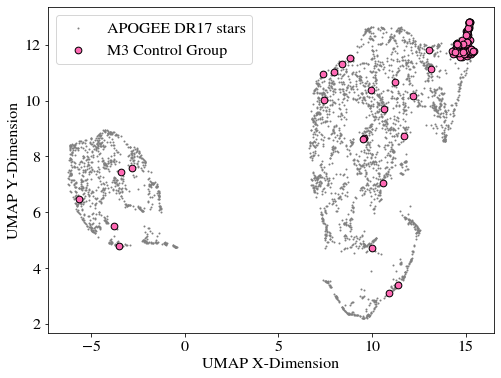

Total: 3184 control: 131


In [13]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(umap_dimX, umap_dimY, s=1, c='gray', label='APOGEE DR17 stars')
ax.scatter(umap_dimX_control , umap_dimY_control, s=45, edgecolor='k', c='hotpink', label='M3 Control Group')
ax.set_xlabel("UMAP X-Dimension", fontsize=16)
ax.set_ylabel("UMAP Y-Dimension", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
ax.legend(fontsize=16)
plt.show()
print('Total:',len(umap_dimX),'control:',len(umap_dimX_control))

Hyperparameters:

- n_neighbors: constrains the size of the neighbourhood UMAP looks at. Low values is very local, high values very global
- min_dist: minimum distance to pack together points. Low values will result in more tight clumps (useful for clustering) while high values will focus on large structure preservation with less clumps
- n_components: dimensionality
- metric: how dist is computed in ambiant space

#### Changing n neighbours (default 15)

In [15]:
# Transpose the standardized + filtered array:
standardized_array_transpose = np.transpose(standardized_array)

# Run t-SNE on the transposed array:
neighbors_list = [5, 10, 50, 100, 150, 200, 250, 500, 1000]
umap_dimX_neigh = []
umap_dimY_neigh = []
umap_dimX_control_neigh = []
umap_dimY_control_neigh = []

for i in neighbors_list:
    reducer_neigh = umap.UMAP(n_neighbors = i)
    embedding_neigh = reducer_neigh.fit_transform(standardized_array_transpose)

    # Get t-SNE outputs for complete filtered dataset:
    umap_dimX_neigh.append(embedding_neigh[:, 0])
    umap_dimY_neigh.append(embedding_neigh[:, 1])

    # Get t-SNE outputs for control group:
    umap_dimX_control_neigh.append(umap_dimX_neigh[-1][indices_control])
    umap_dimY_control_neigh.append(umap_dimY_neigh[-1][indices_control])
    
    print('done neigh n =', i)
print('done neigh')

done neigh n = 5
done neigh n = 10
done neigh n = 50
done neigh n = 100
done neigh n = 150
done neigh n = 200
done neigh n = 250
done neigh n = 500
done neigh n = 1000
done neigh


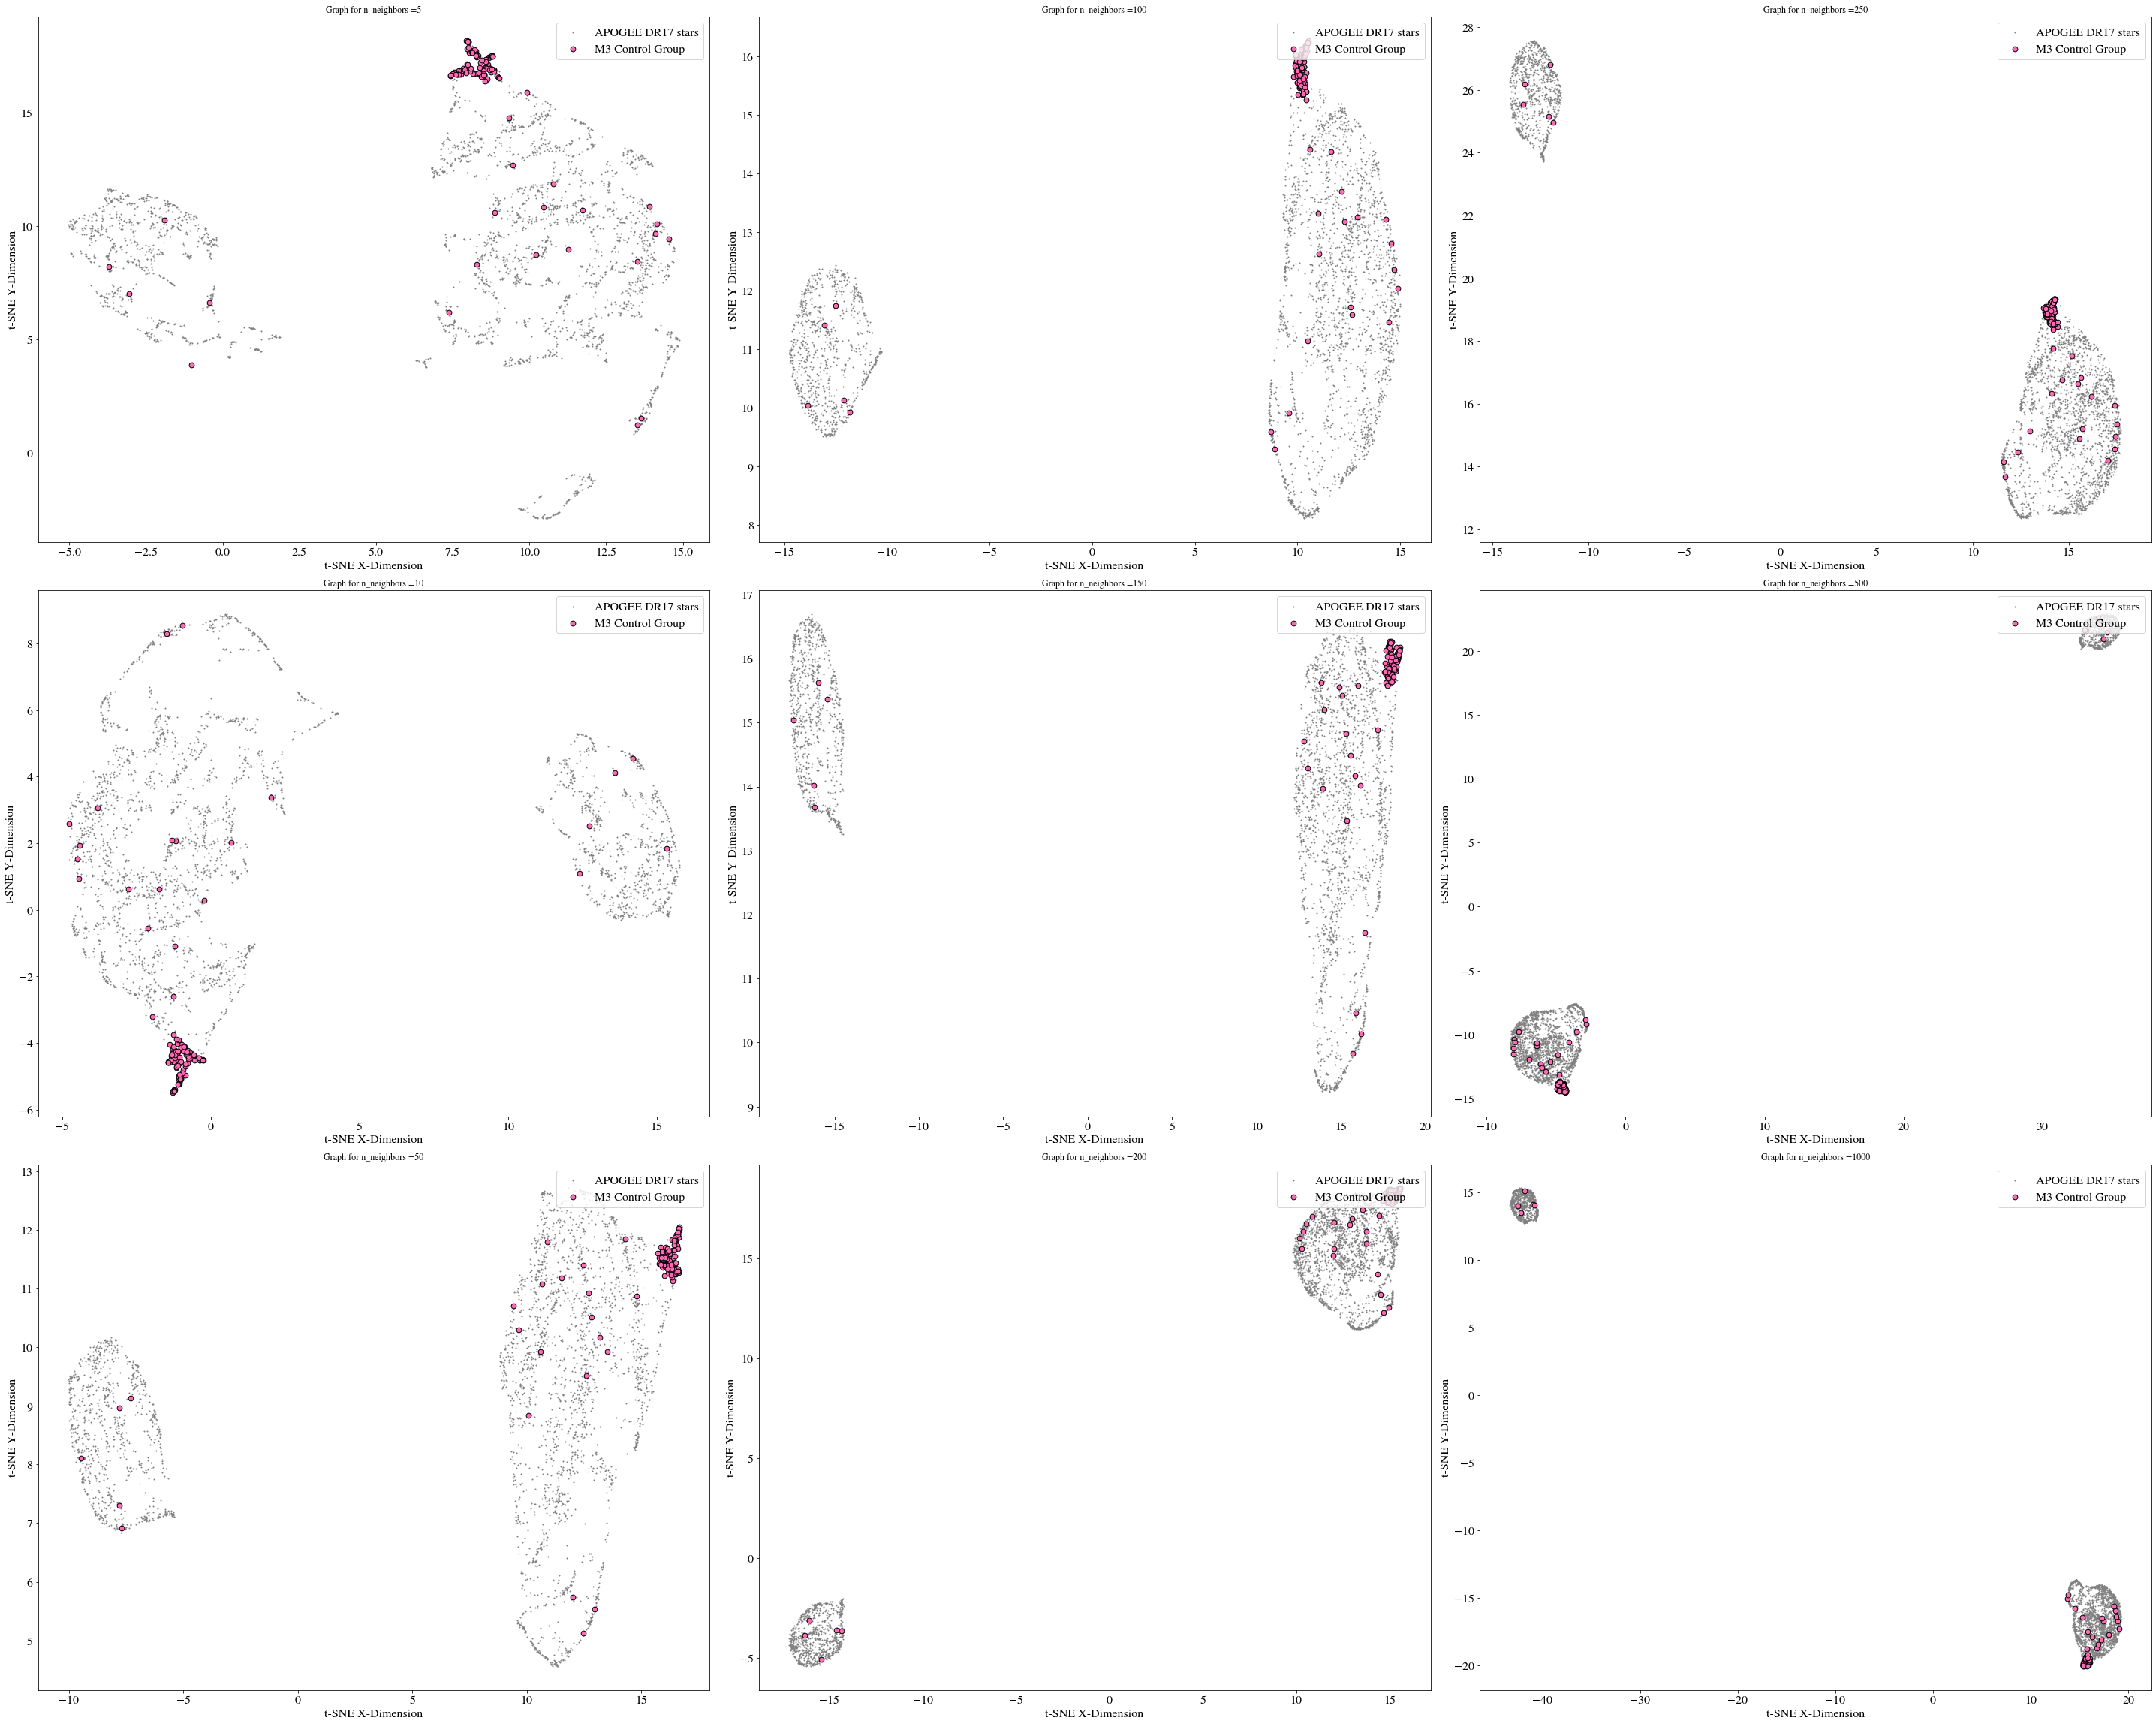

In [17]:
fig_neigh, ax = plt.subplots(3, 3, figsize=(40,32))
for i in range(3):
    for j in range(3):
        ax[i,j].scatter(umap_dimX_neigh[i + 3 * j], umap_dimY_neigh[i + 3 * j], s=1, c='gray', label='APOGEE DR17 stars')
        ax[i,j].scatter(umap_dimX_control_neigh[i + 3 * j], umap_dimY_control_neigh[i + 3 * j], s=45, edgecolor='k', c='hotpink', label='M3 Control Group')
        ax[i,j].set_xlabel("t-SNE X-Dimension", fontsize=16)
        ax[i,j].set_ylabel("t-SNE Y-Dimension", fontsize=16)
        ax[i,j].tick_params(axis='both', which='major', labelsize=16)
        ax[i,j].tick_params(axis='both', which='minor', labelsize=16)
        ax[i,j].set_title('Graph for n_neighbors =' + str(neighbors_list[i + 3 * j]))
        ax[i,j].legend(fontsize=16, loc=1)
plt.tight_layout()
plt.savefig('umap_neigh')
plt.show()

for smaller neighbour n, the two groups are much more dispersed. As n increases the groups become a lot more separate and clustered together, same with the control group stars.

#### changing min_dist (default 0.1)

In [18]:
# Transpose the standardized + filtered array:
standardized_array_transpose = np.transpose(standardized_array)

# Run t-SNE on the transposed array:
dist_list = [0.0, 0.01, 0.05, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9]
umap_dimX_dist = []
umap_dimY_dist = []
umap_dimX_control_dist = []
umap_dimY_control_dist = []

for i in dist_list:
    reducer_dist = umap.UMAP(min_dist = i)
    embedding_dist = reducer_dist.fit_transform(standardized_array_transpose)

    # Get t-SNE outputs for complete filtered dataset:
    umap_dimX_dist.append(embedding_dist[:, 0])
    umap_dimY_dist.append(embedding_dist[:, 1])

    # Get t-SNE outputs for control group:
    umap_dimX_control_dist.append(umap_dimX_dist[-1][indices_control])
    umap_dimY_control_dist.append(umap_dimY_dist[-1][indices_control])
    
    print('done min dist =', i)
print('done min dist')

done min dist = 0.0
done min dist = 0.01
done min dist = 0.05
done min dist = 0.2
done min dist = 0.3
done min dist = 0.5
done min dist = 0.7
done min dist = 0.8
done min dist = 0.9
done min dist


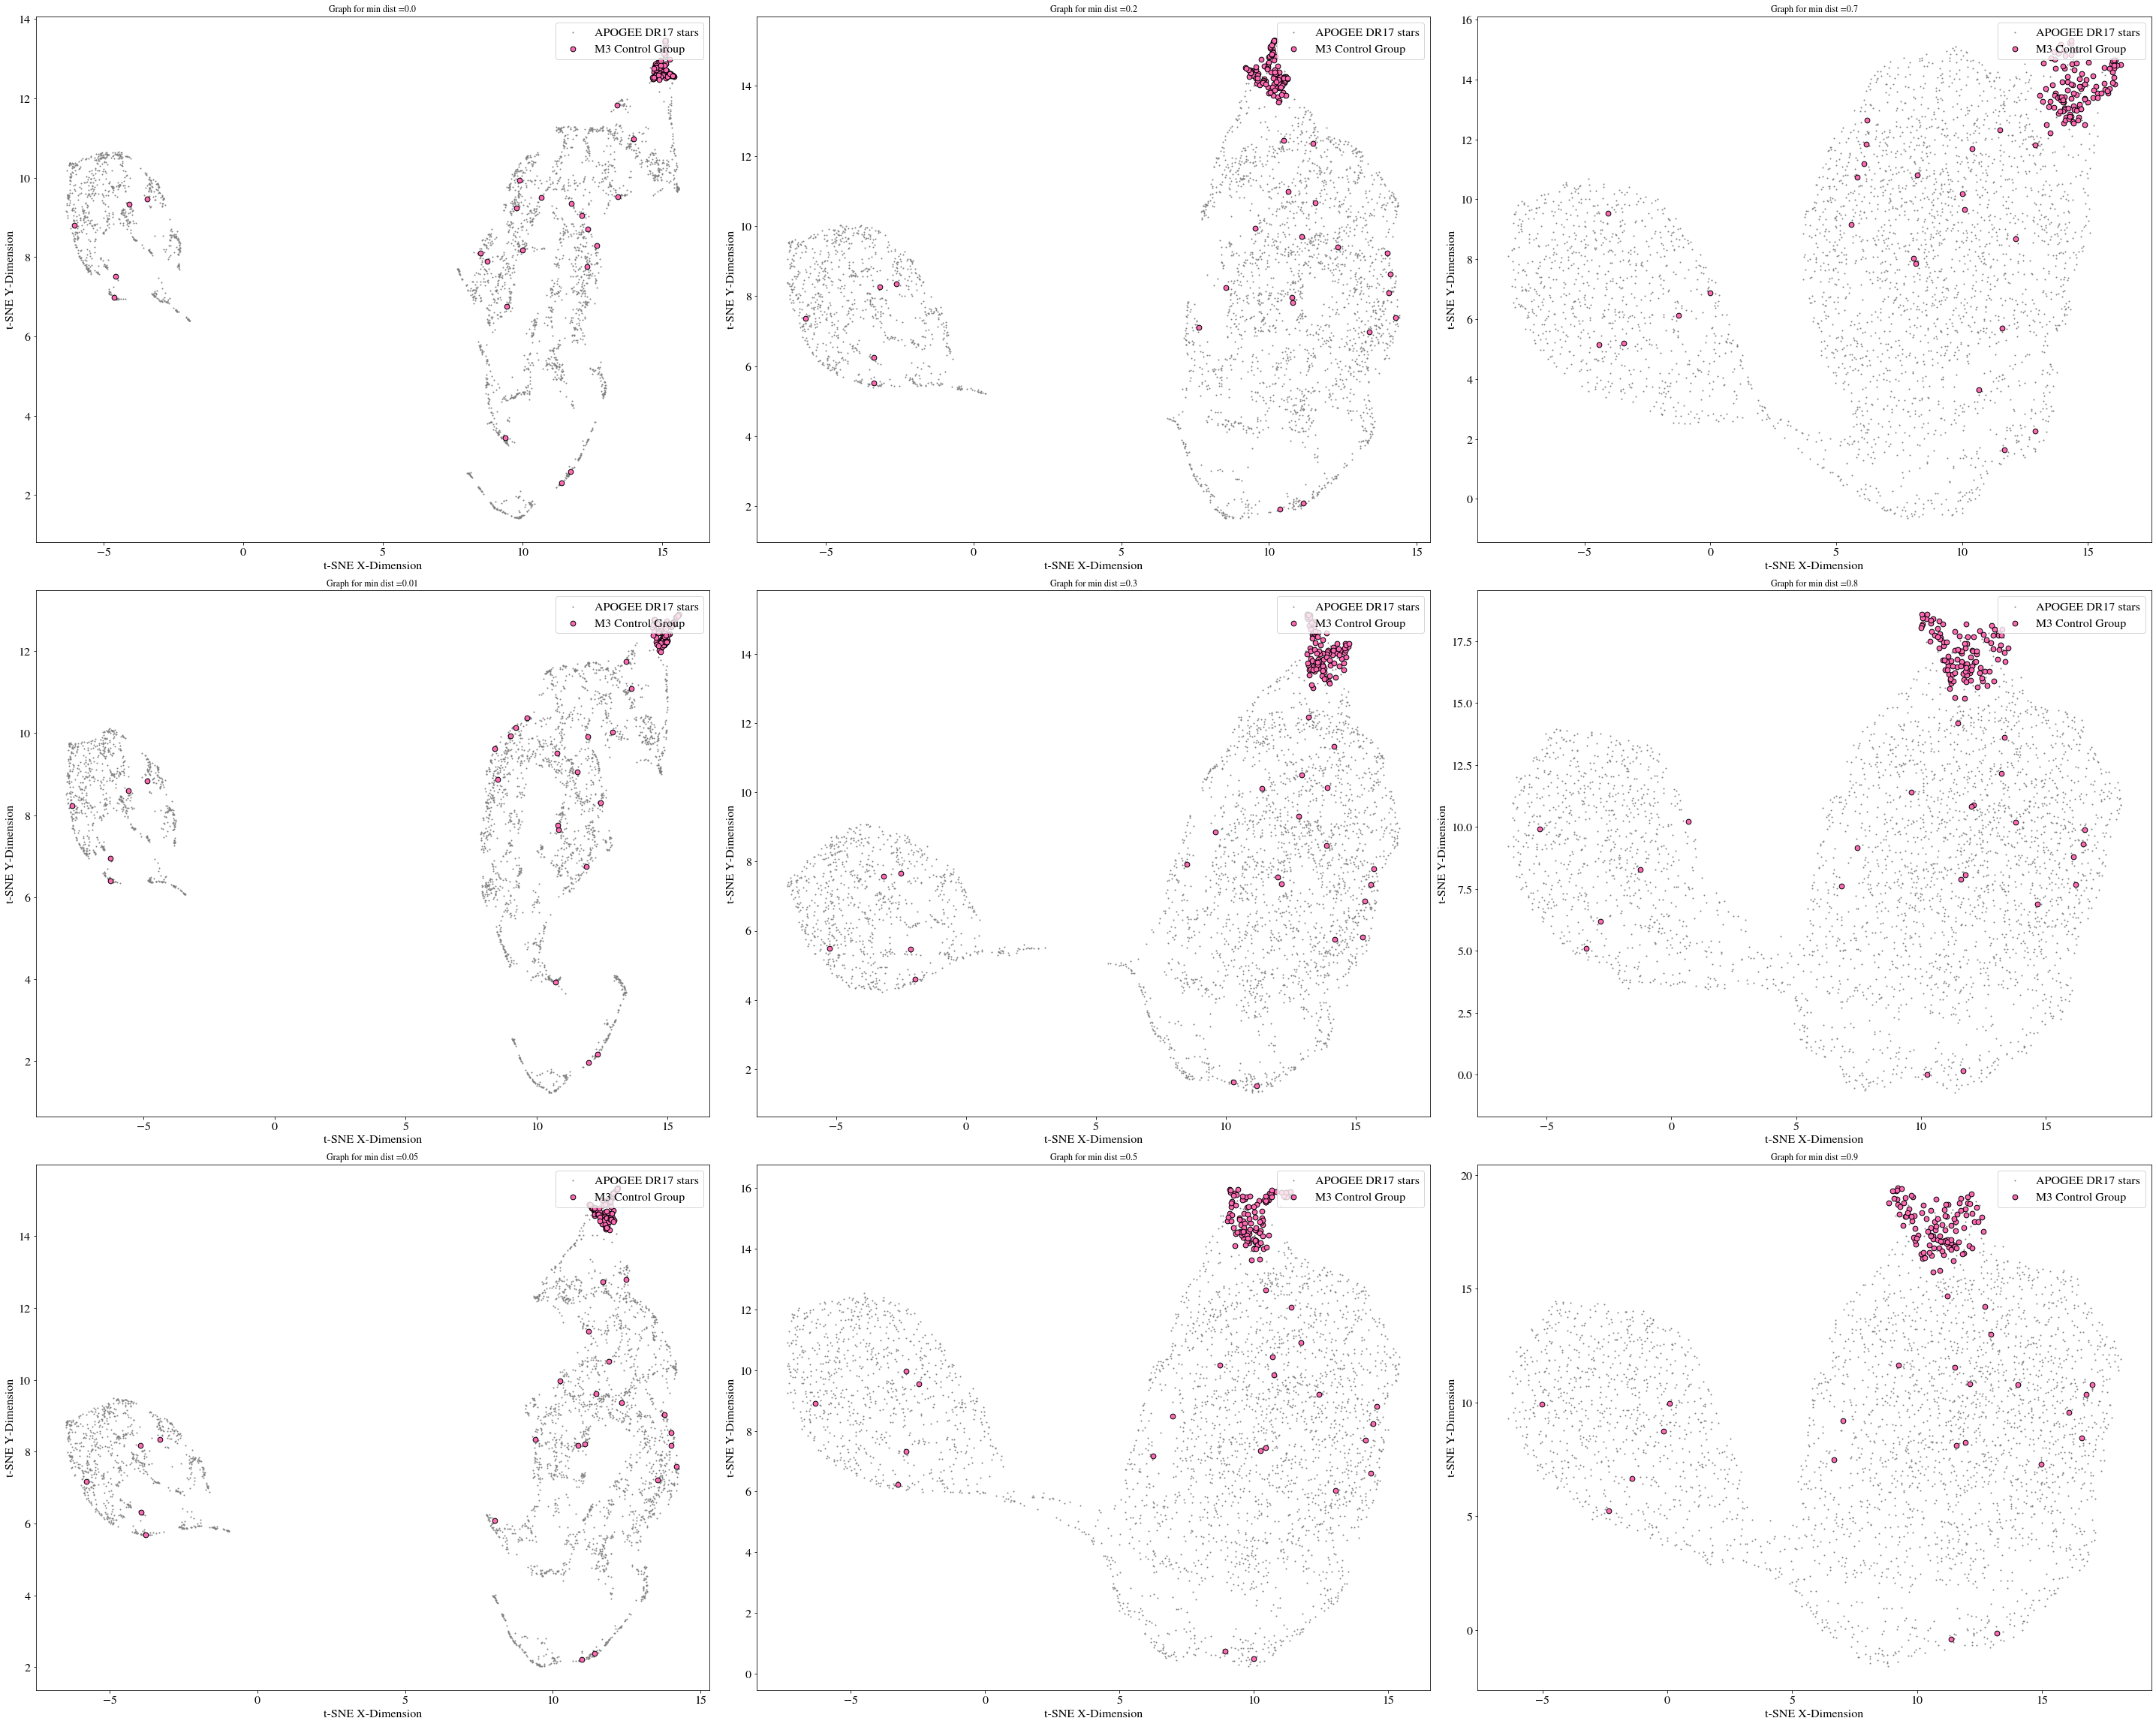

In [19]:
fig_dist, ax = plt.subplots(3, 3, figsize=(40,32))
for i in range(3):
    for j in range(3):
        ax[i,j].scatter(umap_dimX_dist[i + 3 * j], umap_dimY_dist[i + 3 * j], s=1, c='gray', label='APOGEE DR17 stars')
        ax[i,j].scatter(umap_dimX_control_dist[i + 3 * j], umap_dimY_control_dist[i + 3 * j], s=45, edgecolor='k', c='hotpink', label='M3 Control Group')
        ax[i,j].set_xlabel("t-SNE X-Dimension", fontsize=16)
        ax[i,j].set_ylabel("t-SNE Y-Dimension", fontsize=16)
        ax[i,j].tick_params(axis='both', which='major', labelsize=16)
        ax[i,j].tick_params(axis='both', which='minor', labelsize=16)
        ax[i,j].set_title('Graph for min dist =' + str(dist_list[i + 3 * j]))
        ax[i,j].legend(fontsize=16, loc=1)
plt.tight_layout()
plt.savefig('umap_dist')
plt.show()

Smaller min dist is tighter groups as expected. Seen in both total group (large structures) and control group (smaller structures). Almost like a reversal of n_beighbors but not as intense.

### Overall remarks
Not sure if changing metric would help, could be cool to try

#### ***CHECK-IN: You succesfully ran UMAP!*

What does this specific UMAP projection actually tell you? How could you improve this UMAP run? Importantly, how could you extend this method to find extra-tidal candidates of M3?

#### Improving the Dimensionality Reduction
Fine tune the hyper-parameters:
- understand how the different hyper-parameters affect the data
- what combination of hyper-parameters achieve the best separation of the control group?

Helpful documentation:

https://umap-learn.readthedocs.io/en/latest/parameters.html

Dimensional Reduction Astronomy Example:
https://arxiv.org/pdf/2210.02471.pdf